In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, accuracy_score
    )
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Synthetic Fraud data

### Load data

In [4]:
fraud_data = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

## Prepare data  
As before, we'll only encode the categorical columns and train on everything except the 'isFlaggedFraud' column.

In [5]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
categoricals = ['type', 'nameOrig', 'nameDest']
for cat in categoricals:
    fraud_data[cat + '_enc'] = LabelEncoder().fit_transform(fraud_data[cat])

In [7]:
fraud_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_enc,nameOrig_enc,nameDest_enc
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,3,757869,1662094
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,3,2188998,1733924
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,4,1002156,439685
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,5828262,391696
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,3,3445981,828919


In [8]:
fraud_data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_enc', 'nameOrig_enc', 'nameDest_enc'],
      dtype='object')

In [9]:
train_cols = ['step', 'type_enc', 'amount', 'nameOrig_enc', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
             'nameDest_enc']
label_col = ['isFraud']

In [10]:
train_length = np.round(len(fraud_data.index) * 0.9, 0)
train_X = fraud_data.loc[:train_length, train_cols]
train_y = fraud_data.loc[:train_length, label_col]
valid_X = fraud_data.loc[train_length:, train_cols]
valid_y = fraud_data.loc[train_length:, label_col]

Let's see how many fraud cases we've got in our training set.

In [11]:
train_y.sum()

isFraud    4449
dtype: int64

Huh. This is tough. The majority of cases are in the latter half of the dataset - if you want to train it realistically, you have to take its timeline into account. So this way, the model won't have seen even half of the cases it will eventually be exposed to.

## Run simple model (LightGBM)

In [12]:
import lightgbm as lgbm

In [13]:
clf = lgbm.LGBMClassifier(n_estimators=1000, random_state=42, class_weight='balanced', objective='binary')

clf.fit(train_X, np.ravel(train_y), categorical_feature=['type_enc', 'nameOrig_enc', 'nameDest_enc'])

preds = pd.DataFrame(clf.predict(valid_X), columns=['predictions'])

prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

/Users/eikegermann/anaconda3/envs/fraud_detection/lib/python3.8/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['nameDest_enc', 'nameOrig_enc', 'type_enc']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Precision:  0.31884780225256654
Recall:  0.849893730074389
ROC score:  0.9195444764130407
F1 score:  0.46372399797057334
Accuracy score:  0.9883711427053635


So just by using the default settings, if we increase the training dataset from 70% to 90% we expose the model to about half the examples in the dataset. This increases the precision from 0.03 to 0.30, which is much better. Still, it's not exactly amazing.  
Also, we haven't played with any of the models hyperparameters *AT ALL*. Of course we could do that.  
Let's see what else we can do.  
Okay, so just a really dumb test - increase the number of estimators by a factor of 10 to 1000 and we get a precision of 92% and recall of about 47%. NOT BAD for a simple move.  
I'm going to predict that if we set the class weights to 'balanced', that precision will go down and the recall will go up. Let's check that.  
Fascinating - yes, that's exactly what happened. However, we're nowhere near at the optimisation of the lgbm model for classification like this.
We've seen that there were only a few thousand account numbers that repeated, so gathering historical data on the activities of an account does not seem to be useful. A different model could be useful - we could try the most successful model from the imbalanced dataset examples and see if that performs better here as well.
A combination of ExtraTrees with HellingerDistanceCriterion might be very interesting.

As for engineered features, this is a tough one. It might help to first look at feature importances or coefficients in the model before something like differences between origin and destination or anything come into play.

In [14]:
clf.feature_importances_

array([7244,  465, 6906,    0, 6597,  895, 3252, 4266,  375], dtype=int32)

In [15]:
def get_lgbm_varimp(model, train_columns, max_vars=50):
    cv_varimp_df = pd.DataFrame([train_columns, model.feature_importances_]).T
    cv_varimp_df.columns = ['feature_name', 'varimp']
    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)    
    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]
    return cv_varimp_df

def plotImp(model, X, model_name='Current model', num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X})
    plt.figure(figsize=(30, 12))
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('{} Features (avg over folds)'.format(model_name))
    plt.tight_layout()
    plt.show()

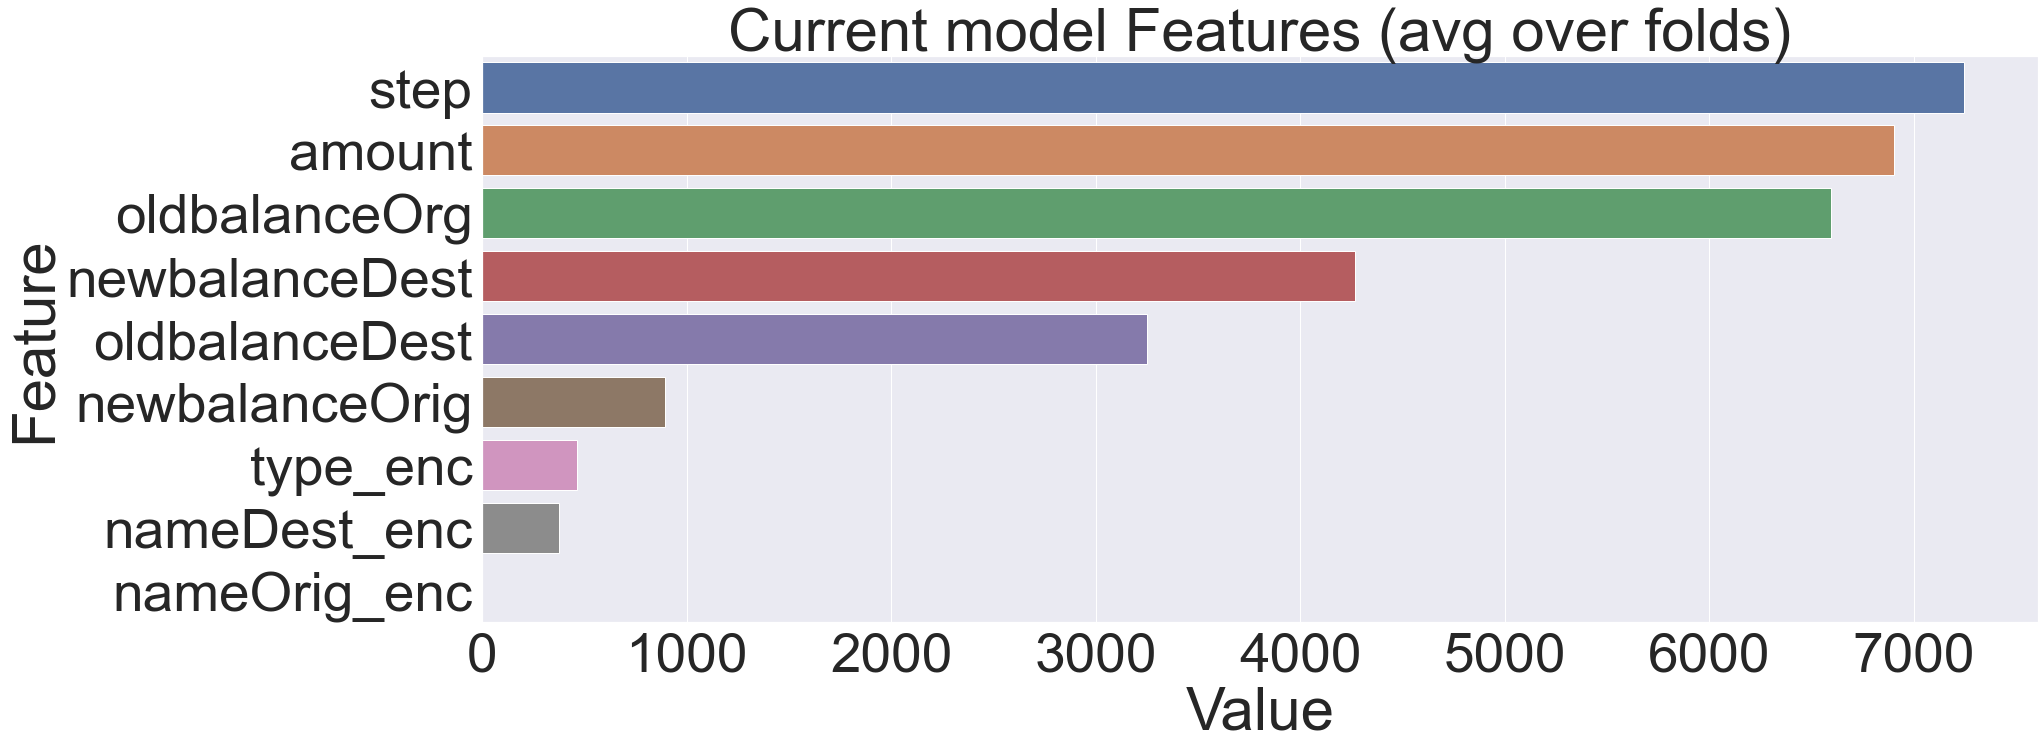

In [16]:
plotImp(clf, train_cols)

Hm, this is a bit odd - one would think that the most important feature to begin with is the type, since there are only two types that contain frauds. But then again, maybe that makes it less important? But wouldn't that cut the problem in half already? Hm. This is not really clear to me.

In [17]:
clf = ExtraTreesClassifier(n_estimators=250, random_state=42, class_weight='balanced')

clf.fit(train_X, np.ravel(train_y))

preds = pd.DataFrame(clf.predict(valid_X), columns=['predictions'])

prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

Precision:  1.0
Recall:  0.69394261424017
ROC score:  0.8469713071200851
F1 score:  0.8193224592220827
Accuracy score:  0.9981894251110391


Uhm. That is a lot cooler than I expected. Uhm. Alright. Now I DEFINITELY want to try the Hellinger distance.  
Anyway, so for fine tuning, we should bring the number of estimators down and introduce a max_depth term to optimise model size.

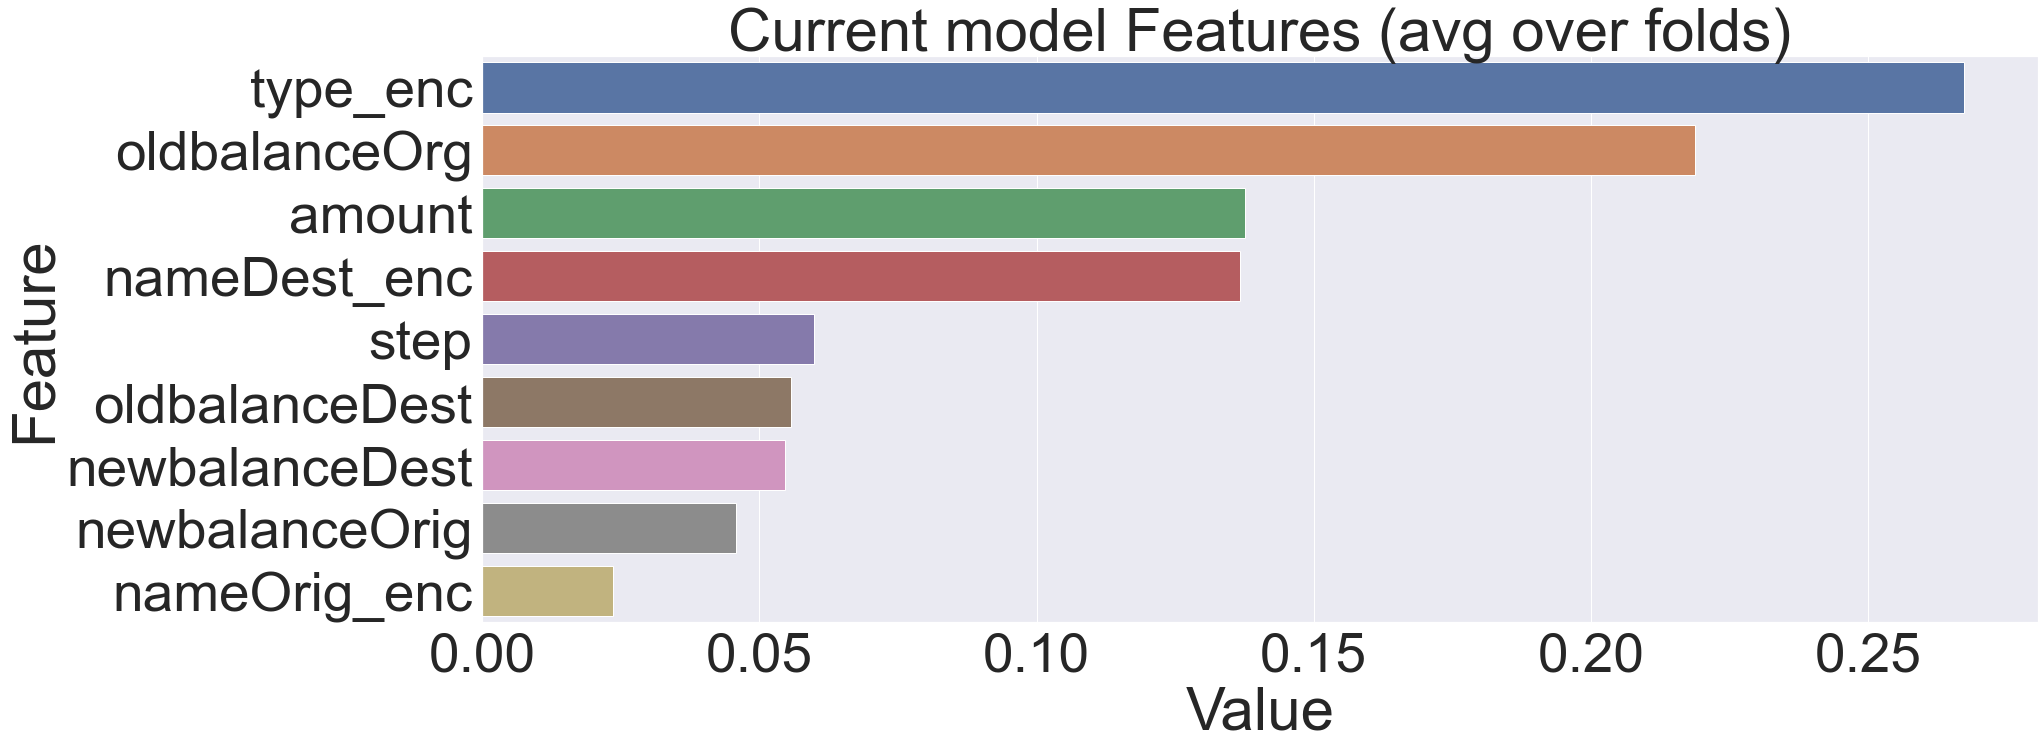

In [18]:
plotImp(clf, train_cols)

In [19]:
from hellinger_distance_criterion import HellingerDistanceCriterion
hdc = HellingerDistanceCriterion(1, np.array([2],dtype='int64'))

clf = ExtraTreesClassifier(criterion=hdc, n_estimators=250, random_state=42, class_weight='balanced')


clf.fit(train_X, np.ravel(train_y))

preds = pd.DataFrame(clf.predict(valid_X), columns=['predictions'])

prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

Precision:  1.0
Recall:  0.6849096705632306
ROC score:  0.8424548352816152
F1 score:  0.8129927467675813
Accuracy score:  0.9981359880049414


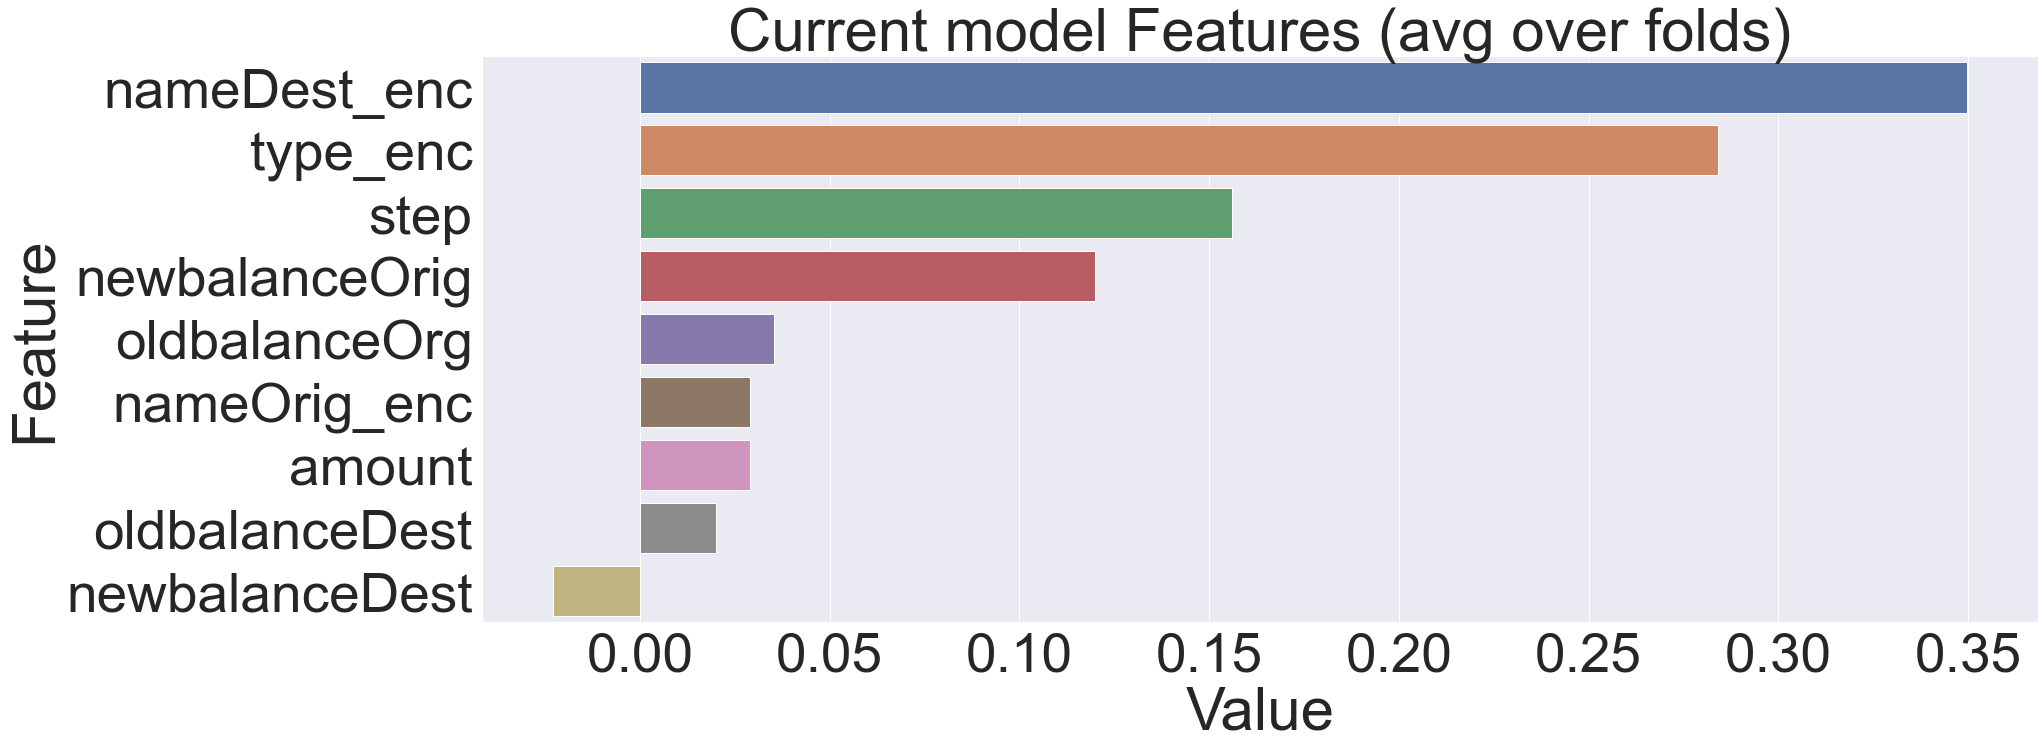

In [20]:
plotImp(clf, train_cols)

Okay, so we've got numerical encodings for our name features - which *might* be meaningless, but according to this graph are not. Now, these are not ordinal. It make make sense to give them a binary encoding instead. I'll have a look at how many columns that would be.

In [21]:
fraud_data.nameDest_enc.max()

2722361

In [22]:
len(f'{2722362:b}')

22

In [23]:
fraud_data.nameOrig_enc.max()

6353306

In [24]:
len(f'{6353306:b}')

23

Hm. Okay, so assuming that there aren't any numbers twice as large in the whole dataset (unlikely, but we could encode both with 23 bits for safety), this would add 46 columns to the dataset. Why, though? Is that worth it? Or is it worth, from here, to examine which options will give us a more reliable increase of Recall.  
According to the list, only more data will give us what we want - which is great, because we have a simulator, but at the same time is unrealistic, because we don't have that situation in real life, even if we have a good data synthesizer. So infinite data is not where it's at. We could try the GAN to keep the example realistic and we could try the random Oversampler, which has the best F1-Score followed by OneSidedSelection.  
This should be a great test, since I haven't used either with the ExtraTrees.  
Also: ExtraTrees boosts Precision. The BalancedRF is also very good at Recall, so it's worth trying. This is also an easy change.

In [25]:
from imblearn.ensemble import BalancedRandomForestClassifier

Using TensorFlow backend.


In [26]:
hdc = HellingerDistanceCriterion(1, np.array([2],dtype='int64'))

clf = BalancedRandomForestClassifier(criterion=hdc, n_estimators=250, random_state=42, class_weight='balanced')

clf.fit(train_X, np.ravel(train_y))

preds = pd.DataFrame(clf.predict(valid_X), columns=['predictions'])

prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

Precision:  0.25464029264327326
Recall:  0.9986716259298618
ROC score:  0.9906377617457965
F1 score:  0.4058080535463673
Accuracy score:  0.9826989510610409


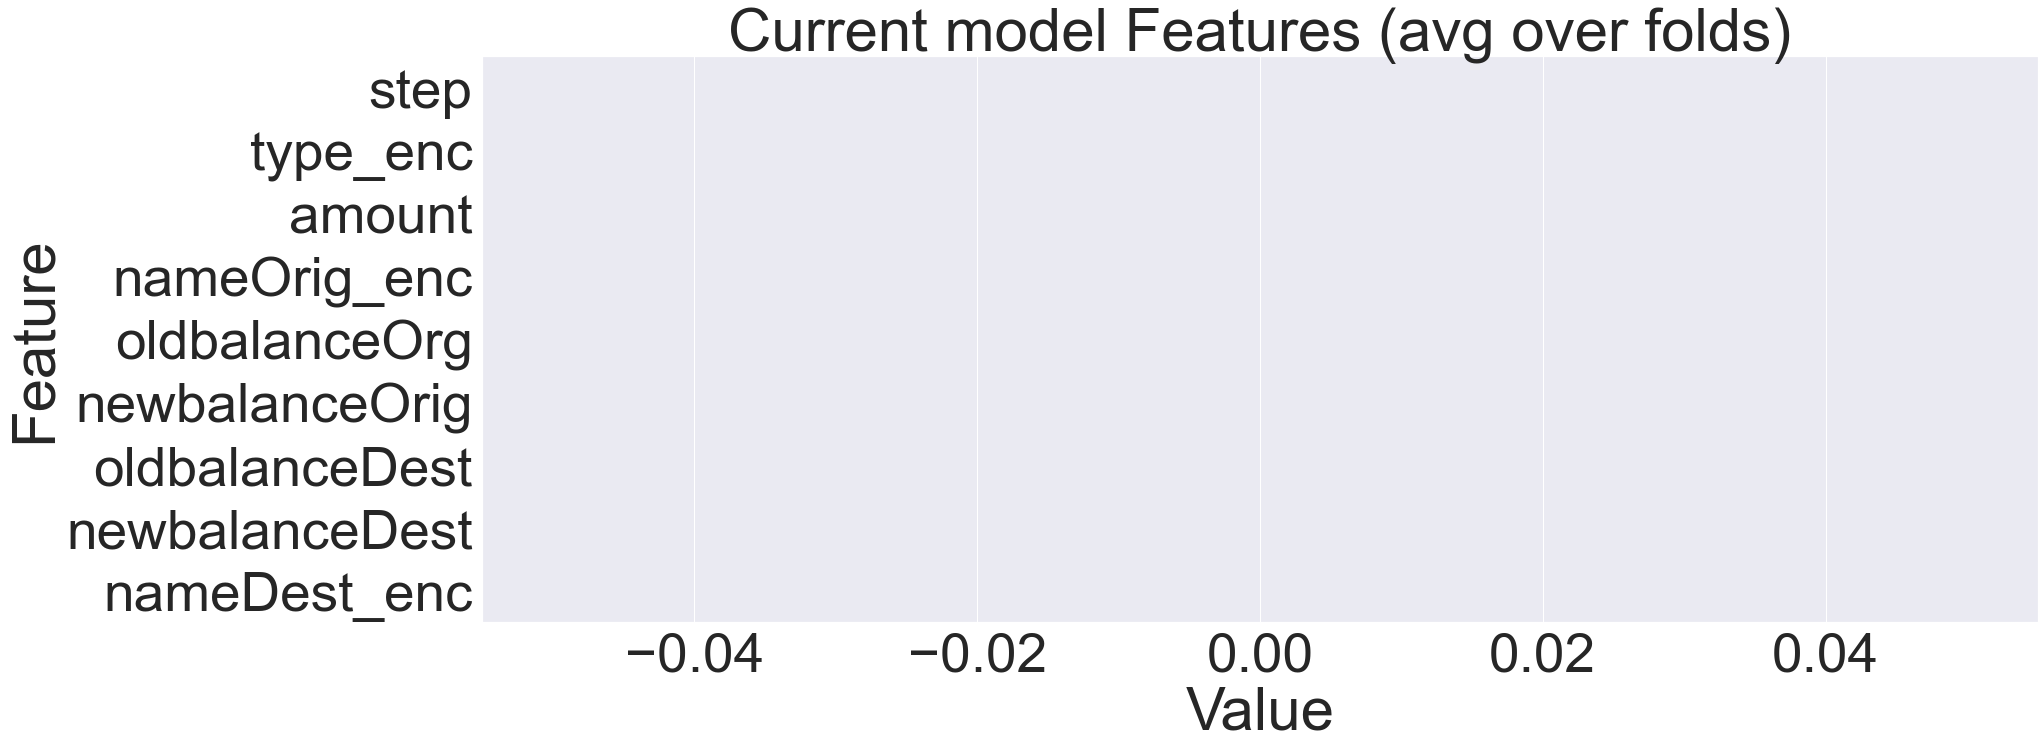

In [27]:
plotImp(clf, train_cols)

Okay, great. This is also very cool to see. I'd love to run the gamut of algorithms on this dataset to see if the general tendencies hold.

In [28]:
from imblearn.under_sampling import OneSidedSelection

In [29]:
oness = OneSidedSelection(random_state=42)

train_X_resampled, train_y_resampled = oness.fit_resample(train_X, train_y)

clf = ExtraTreesClassifier(criterion=hdc, n_estimators=250, random_state=42, class_weight='balanced')

clf.fit(train_X_resampled, np.ravel(train_y_resampled))

preds = pd.DataFrame(clf.predict(valid_X), columns=['predictions'])

prec = precision_score(valid_y, preds)
reca = recall_score(valid_y, preds)
roc = roc_auc_score(valid_y, preds)
f1 = f1_score(valid_y, preds)
acc = accuracy_score(valid_y, preds)
conf_mat = confusion_matrix(valid_y, preds)

print("Precision: ", prec)
print("Recall: ", reca)
print("ROC score: ", roc)
print("F1 score: ", f1)
print("Accuracy score: ", acc)

Precision:  0.9992079207920792
Recall:  0.6702975557917109
ROC score:  0.8351471968631883
F1 score:  0.8023533153124502
Accuracy score:  0.998046402268248


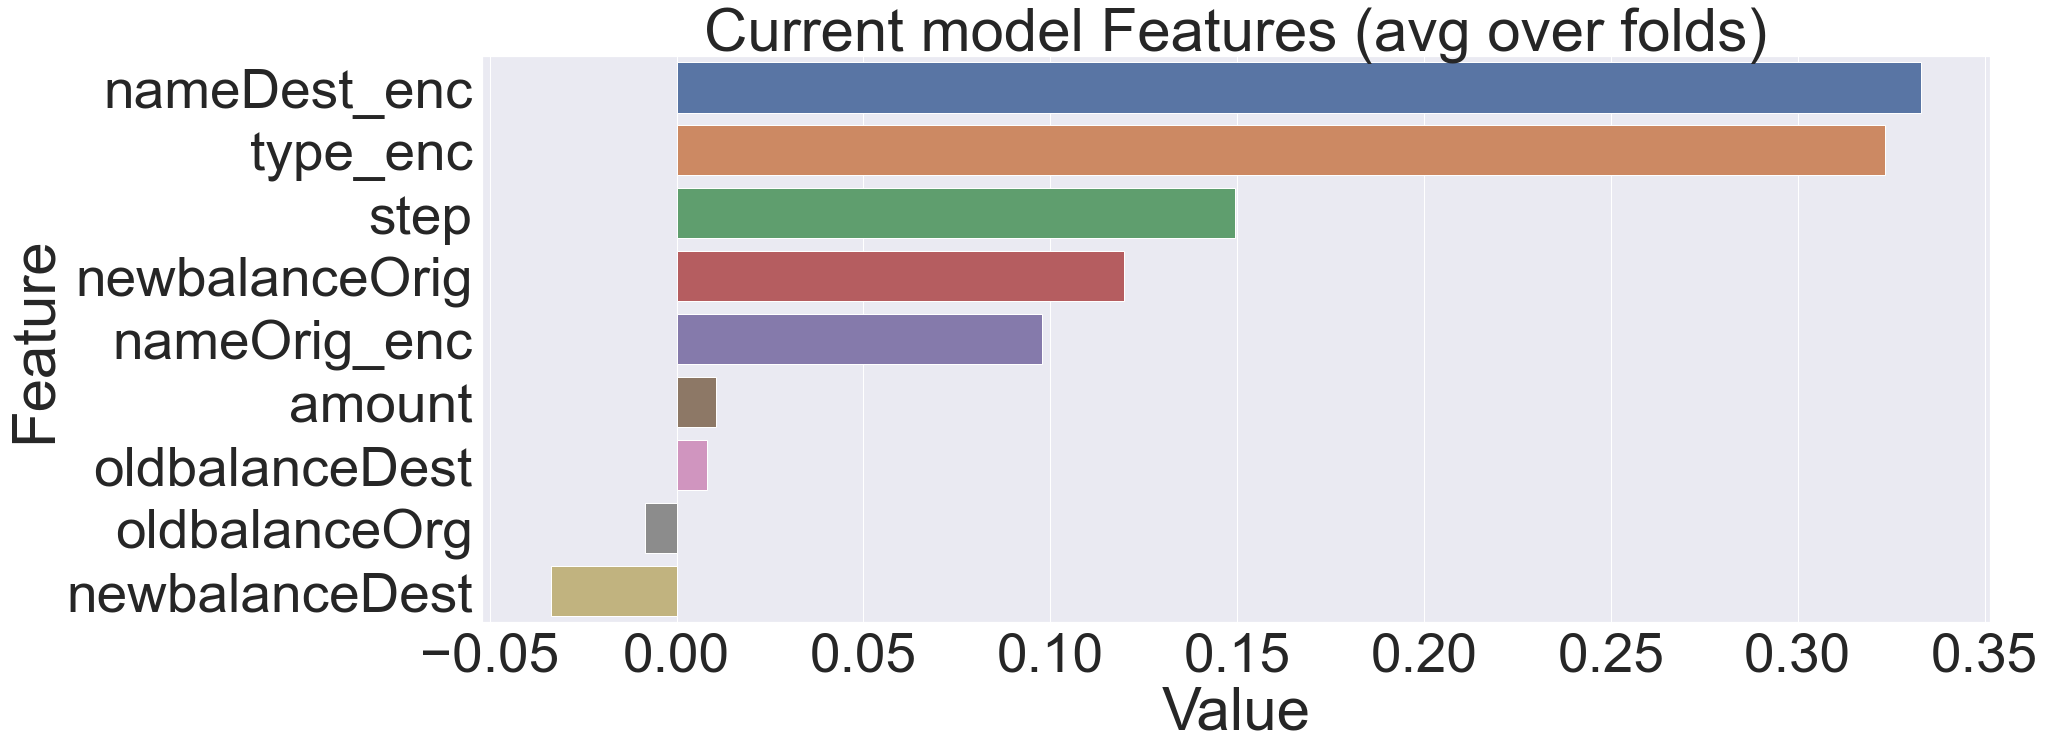

In [30]:
plotImp(clf, train_cols)

In [31]:
from category_encoders.binary import BinaryEncoder

In [32]:
benc = BinaryEncoder()

In [33]:
benc.fit_transform(fraud_data.loc[0:10, 'nameOrig'])

,nameOrig_0,nameOrig_1,nameOrig_2,nameOrig_3,nameOrig_4
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,0,1,1
3,0,0,1,0,0
4,0,0,1,0,1
5,0,0,1,1,0
6,0,0,1,1,1
7,0,1,0,0,0
8,0,1,0,0,1
9,0,1,0,1,0


Gah, this is getting messy. Let's use a new notebook instead.